In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from extract_dynamical_systems import finite_difference, least_squares_minimization, calculate_x_from_vector, plot_phase_diagram, calculate_new_data_and_derivatives_linear, calculate_new_data_and_derivatives_rbf, right_hand_side, solve_linear_system, rbf, find_radial_basis_function_means, phi

# First Part

### Load and plot original data

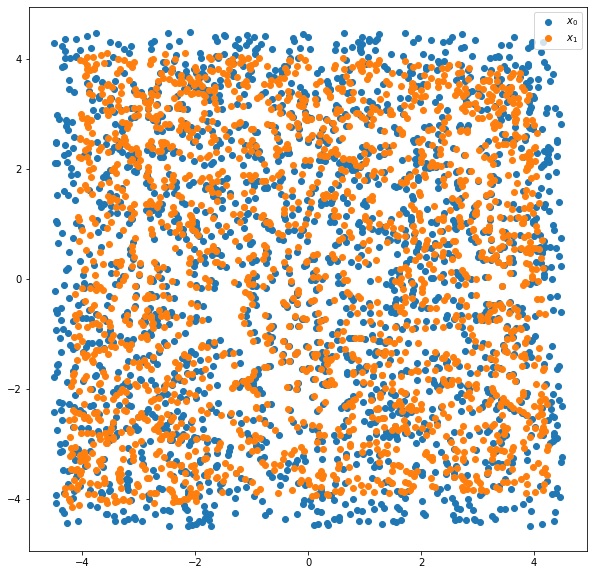

In [2]:
# load data
data_x0 = np.loadtxt('task3/nonlinear_vectorfield_data_x0.txt')
data_x1 = np.loadtxt('task3/nonlinear_vectorfield_data_x1.txt')
# plot data
fig = plt.figure(figsize=(10, 10))
plt.scatter(data_x0[:, 0], data_x0[:, 1], label='$x_0$')
plt.scatter(data_x1[:, 0], data_x1[:, 1], label='$x_1$')
plt.legend()
plt.savefig('task3/Figures/X0_and_X1_data')

### Plot flow between the first and the second timestep

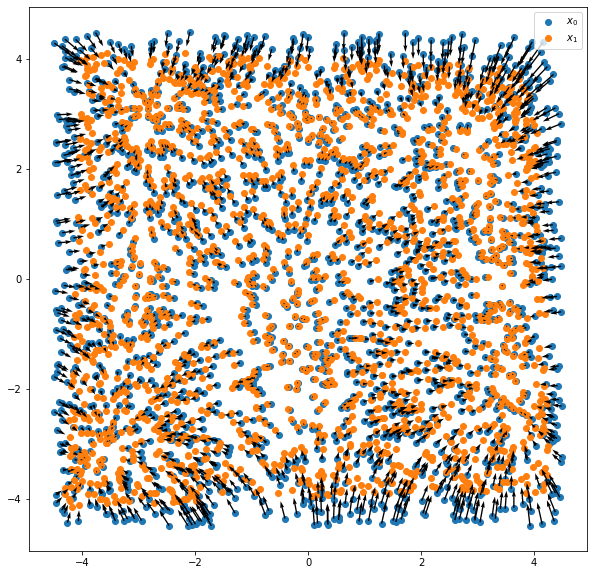

In [3]:
# calculate and plot vector field
delta_t = 0.01
xd, yd = finite_difference(data_x0, data_x1, delta_t).T 
fig = plt.figure(figsize=(10,10))
plt.scatter(data_x0[:, 0], data_x0[:, 1], label='$x_0$')
plt.scatter(data_x1[:, 0], data_x1[:, 1], label='$x_1$')
plt.quiver(data_x0[:, 0], data_x0[:, 1], xd, yd)
plt.legend()
plt.savefig('task3/Figures/linear_vector_fied')

### Calculate $\Delta_t$

In [4]:
#calculate the delta_t which minimizes the mean squared error of part two (manual tests have shown it is between 0.08 and 0.12)
delta_t_min = 1.0
mse_min = 1.0
for delta_t in np.arange(0.08, 0.12, 0.001):
    #approximate vector field v_hat via difference formula of x_0 and x_1 using delta_t
    v_hat = finite_difference(data_x0, data_x1, delta_t)
    #approximate the matrix A_hat
    A_hat = least_squares_minimization(data_x0, v_hat, rcond=None)
    #solve linear system up to t_end = 0.1 to obatain x1_hat
    x1_hat = solve_linear_system(A=A_hat, start_points=data_x0, t_0=0.0, t_end=0.1, resolution=1000)
    #compute mean squared error and check if it is smaller
    mse = mean_squared_error(data_x1, x1_hat)
    if mse < mse_min:
        mse_min = mse
        delta_t_min = delta_t
    else:
        break

print(f"A value of around {delta_t_min:.3} for Delta_t minimizes the Mean Squared Error of part two (MSE = {mse_min}).")

A value of around 0.098 for Delta_t minimizes the Mean Squared Error of part two (MSE = 0.018635138782127424).


### Plot approximations for different values $\Delta_t$

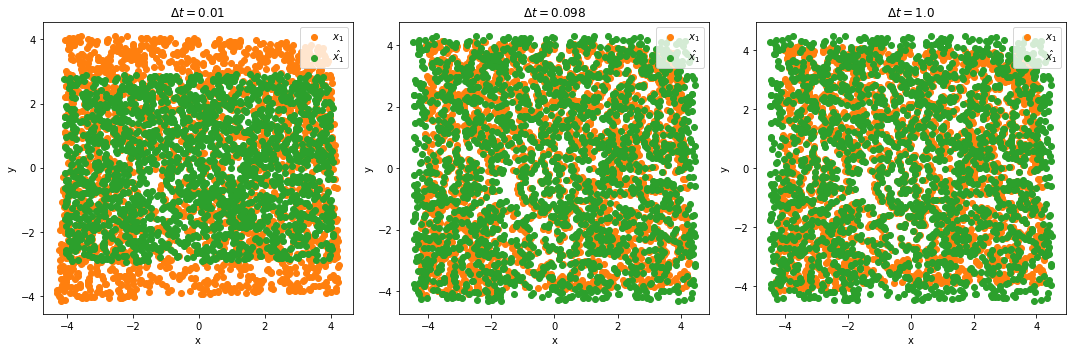

In [5]:
#plot approximated x1_hat for different values of delta_t including the found best one
delta_t = delta_t_min

delta_ts = [0.01, delta_t, 1.0]
fig, ax = plt.subplots(1,len(delta_ts), figsize=(len(delta_ts) * 5, 5))
# mean squared errors for different delta_t
mses = []

for i, delta_t in enumerate(delta_ts):
    #approximate vector field v_hat via difference formula of x_0 and x_1 using the found delta_t
    v_hat = finite_difference(data_x0, data_x1, delta_t)
    #approximate the matrix A_hat
    A_hat = least_squares_minimization(data_x0, v_hat, rcond=None)
    #solve linear system up to t_end = 0.1 to obatain x1_hat
    x1_hat = solve_linear_system(A=A_hat, start_points=data_x0, t_0=0.0, t_end=0.1, resolution=1000)
    mses.append(mean_squared_error(x1_hat, data_x1))
    ax[i].scatter(data_x1[:,0], data_x1[:,1], label='$x_1$', c='tab:orange')
    ax[i].scatter(x1_hat[:,0], x1_hat[:,1], label='$\hat{x_1}$', c='tab:green')
    ax[i].set_xlabel('x')
    ax[i].set_ylabel('y')
    ax[i].legend(loc='upper right')
    ax[i].set_title("$\Delta t = $" + f"{delta_t:.3}")
plt.tight_layout()
plt.savefig('task3/Figures/delta_t_linear')

### Calculate Linear Operator A

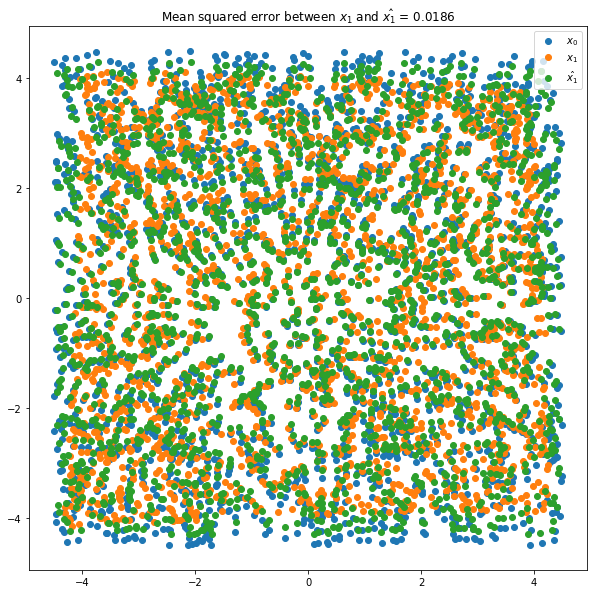

In [6]:
delta_t = delta_t_min
# calculate v1
v1 = finite_difference(data_x0, data_x1, delta_t)
# calculate matrix A using least squares method
A = least_squares_minimization(data_x0, v1, rcond=None)

# project new data
v1_hat = data_x0.dot(A.T)
new_data_x1 = calculate_x_from_vector(v1_hat, data_x0, delta_t)

# calculate mean squared error
mse = mean_squared_error(data_x1, new_data_x1)
fig = plt.figure(figsize=(10,10))
plt.title(r"Mean squared error between $x_1$ and $\hat{x_1}$ = " + f"{mse:.3}")
plt.scatter(data_x0[:,0], data_x0[:,1], label='$x_0$')
plt.scatter(data_x1[:, 0], data_x1[:, 1], label="$x_1$")
plt.scatter(new_data_x1[:, 0], new_data_x1[:, 1], label='$\hat{x_1}$')
plt.legend(loc="upper right")
plt.savefig('task3/Figures/projected_data_linear')

# Second part

### Define radial basis function required for approximation

In [7]:
# define epsilon
epsilon = 0.01
# get centers for radial basis function
radial_means = find_radial_basis_function_means(data_x0,300)
print(radial_means.shape)

(300, 2)


### Find $\Delta_t$ for approximation

In [8]:
#calculate the delta_t which minimizes the mean squared error of part two (manual tests have shown it is between 0.09 and 0.12)
delta_t_min = 1.0
mse_min = 1.0
for delta_t in np.arange(0.09, 0.12, 0.001):
    phi_on_X0 = phi(data_x0, radial_means, epsilon)
    #approximate vector field v_hat via difference formula of x_0 and x_1 using delta_t
    v_hat = finite_difference(data_x0, data_x1, delta_t)
    #approximate the matrix A_hat
    A_hat_t = least_squares_minimization(phi_on_X0, v1, rcond=2).T
    #approxiate x1
    x1_hat = calculate_x_from_vector(phi_on_X0.dot(A_hat_t), data_x0, delta_t)
    
    #compute mean squared error and check if it is smaller
    mse = mean_squared_error(data_x1, x1_hat)
    if mse < mse_min:
        mse_min = mse
        delta_t_min = delta_t
    else:
        break

print(f"A value of around {delta_t_min:.3} for Delta_t minimizes the Mean Squared Error (MSE = {mse_min}).")

A value of around 0.098 for Delta_t minimizes the Mean Squared Error (MSE = 0.005479406617510283).


### Plot projection of projected data

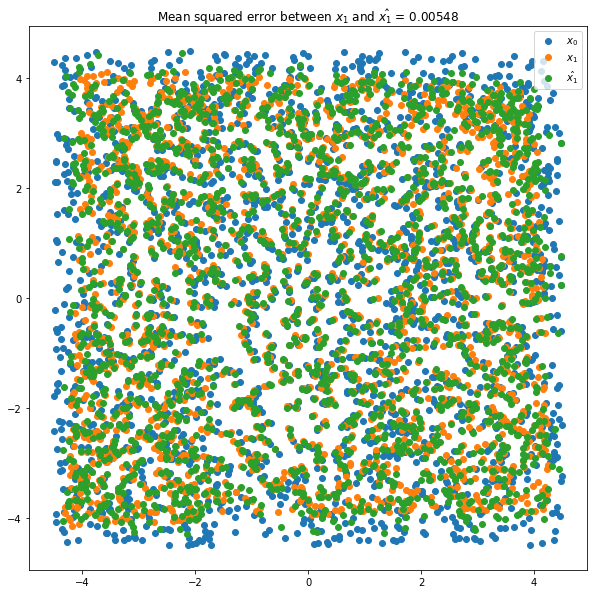

In [9]:
# set best approximation for delta_t
delta_t = delta_t_min

# apply phi function on data
phi_on_X0 = phi(data_x0, radial_means, epsilon)
# calculate matrix A using least squared method
A_t = least_squares_minimization(phi_on_X0, v1, rcond=2).T
new_data_v1 = phi_on_X0.dot(A_t)
new_data_x1 = calculate_x_from_vector(new_data_v1, data_x0, delta_t)
# calculate mean squared error
mse = mean_squared_error(data_x1, new_data_x1)
# plot original and projected data
fig = plt.figure(figsize=(10,10))
plt.title(r"Mean squared error between $x_1$ and $\hat{x_1}$ = " + f"{mse:.3}")
plt.scatter(data_x0[:,0], data_x0[:,1], label='$x_0$')
plt.scatter(data_x1[:, 0], data_x1[:, 1], label="$x_1$")
plt.scatter(new_data_x1[:, 0], new_data_x1[:, 1], label='$\hat{x_1}$')
plt.legend(loc="upper right")
plt.savefig('task3/Figures/projected_data_nonlinear')

### Plot overfitted data

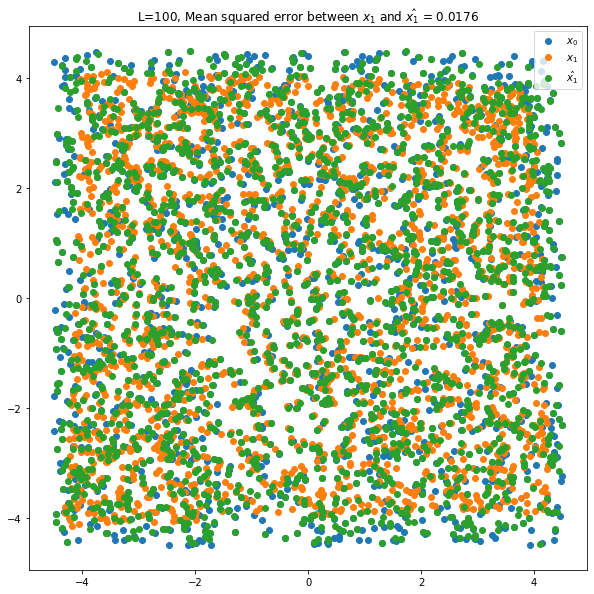

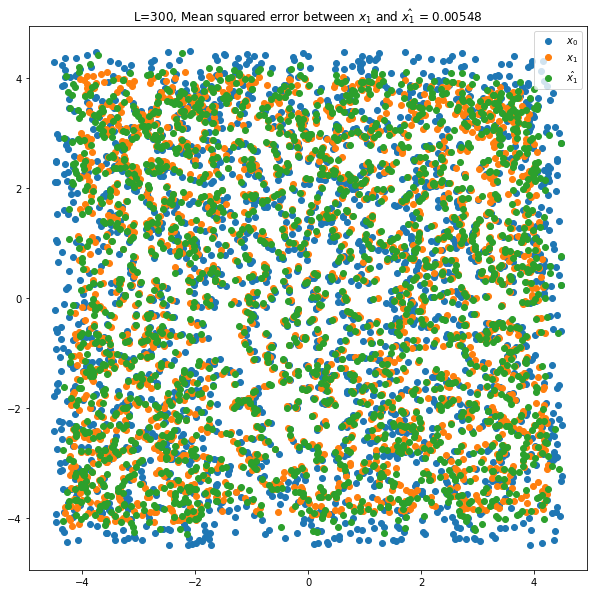

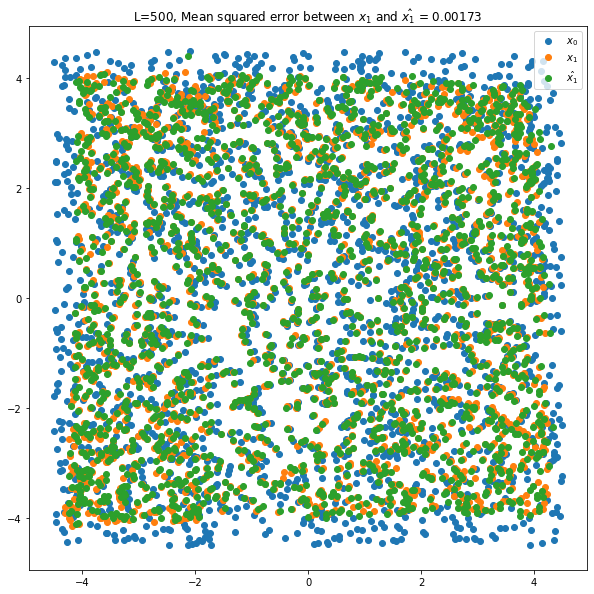

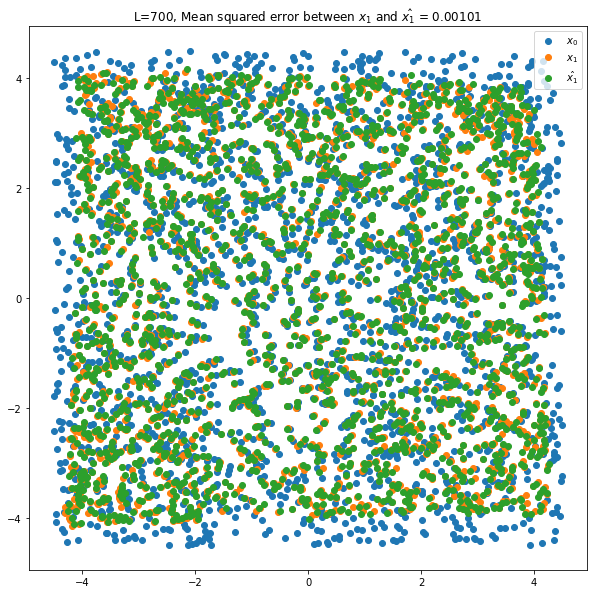

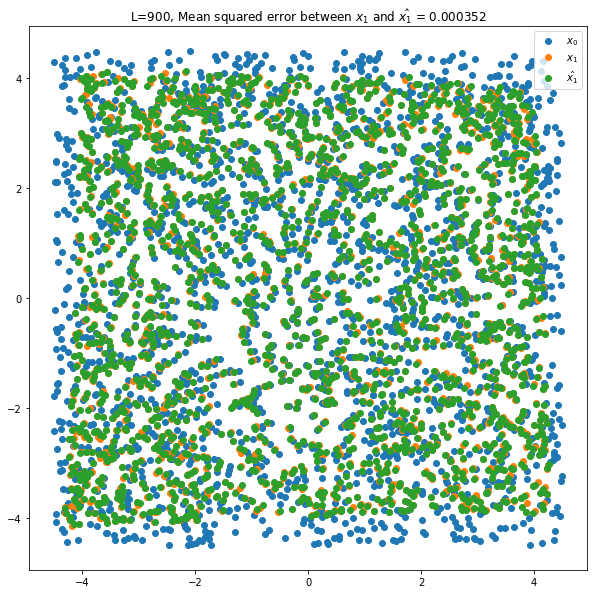

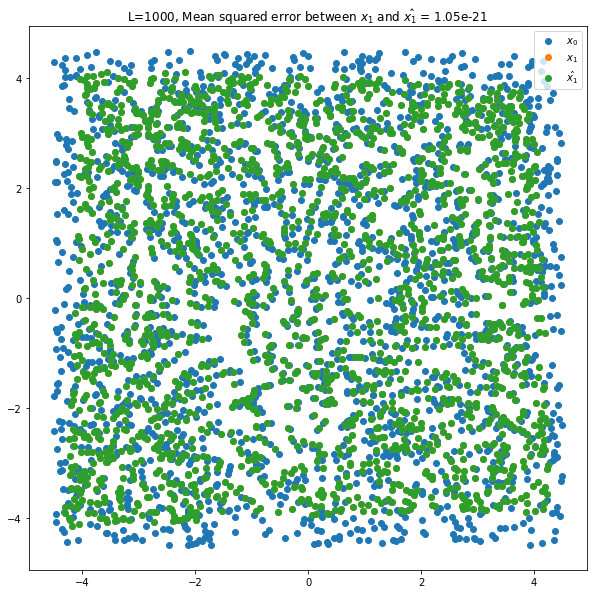

In [10]:
# define different L values for which projection is plotted
centers = [100, 300, 500, 700, 900, 1000]

for center in centers:
    radial_means_iter = find_radial_basis_function_means(data_x0,center)
    # apply phi function on data
    phi_on_X0 = phi(data_x0, radial_means_iter, epsilon)
    # calculate matrix A using least squared method
    A_t = least_squares_minimization(phi_on_X0, v1, rcond=2).T
    new_data_v1 = phi_on_X0.dot(A_t)
    new_data_x1 = calculate_x_from_vector(new_data_v1, data_x0, delta_t)
    # calculate mean squared error
    mse = mean_squared_error(data_x1, new_data_x1)
    # plot original and projected data
    fig = plt.figure(figsize=(10,10))
    plt.title(r"L=" + f"{center}" +", Mean squared error between $x_1$ and $\hat{x_1}$ = " + f"{mse:.3}")
    plt.scatter(data_x0[:,0], data_x0[:,1], label='$x_0$')
    plt.scatter(data_x1[:, 0], data_x1[:, 1], label="$x_1$")
    plt.scatter(new_data_x1[:, 0], new_data_x1[:, 1], label='$\hat{x_1}$')
    plt.legend(loc="upper right")
    plt.savefig('task3/Figures/L'+ str(center) + 'projected_data_nonlinear')

# Third part

### Plot phase diagram for linear vector approximation

C:\Users\eminm\anaconda3\lib\site-packages\matplotlib\quiver.py:679: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
C:\Users\eminm\anaconda3\lib\site-packages\matplotlib\quiver.py:679: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


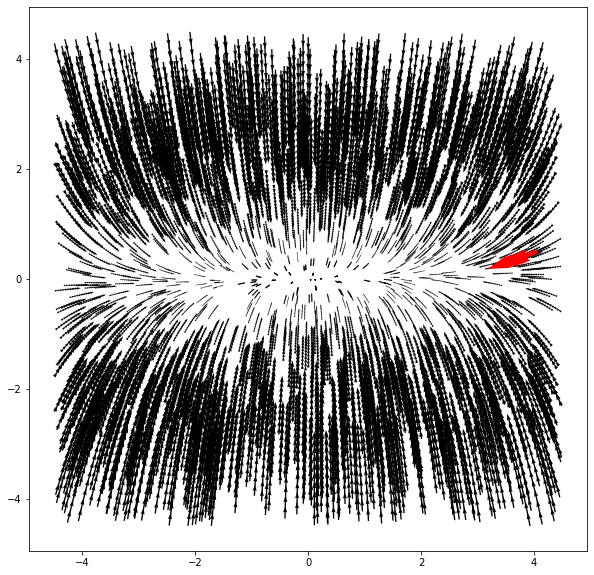

In [11]:
# calculate matrix A
v1 = finite_difference(data_x0, data_x1, delta_t)
A_t = least_squares_minimization(data_x0, v1, rcond=None).T

# calculate projected data and flows required for phase diagram
projected_data, projected_vectors = calculate_new_data_and_derivatives_linear(10, A_t, data_x0, delta_t)

# plot phase diagram
fig = plt.figure(figsize=(10,10))
plot_phase_diagram(projected_data, projected_vectors)
plt.savefig('task3/Figures/linear_phase_diagram')

### Plot phase digram for nonlinear vector approximation using Radial basis function

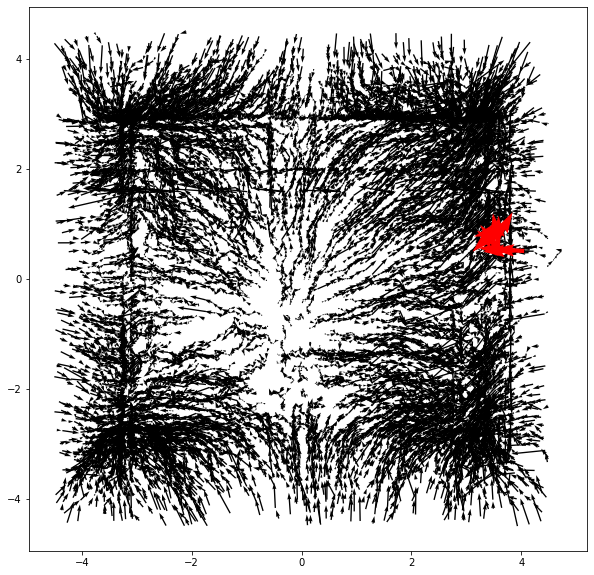

In [12]:
# calculate Matrix C 
v1 = finite_difference(data_x0, data_x1, delta_t)
C_t = least_squares_minimization(phi(data_x0, radial_means, epsilon), v1, rcond=2).T

def phi_constants(x): return phi(x, radial_means, epsilon)

# calculate projected data and flows
projected_data, projected_vectors = calculate_new_data_and_derivatives_rbf(10, C_t, data_x0, delta_t, phi_constants)

# plot phase diagram
fig = plt.figure(figsize=(10,10))
plot_phase_diagram(projected_data, projected_vectors)
plt.savefig('task3/Figures/nonlinear_phase_diagram')

# Additional with scipy.interpolate.Rbf function

### Define Rbf function and plot projected X1

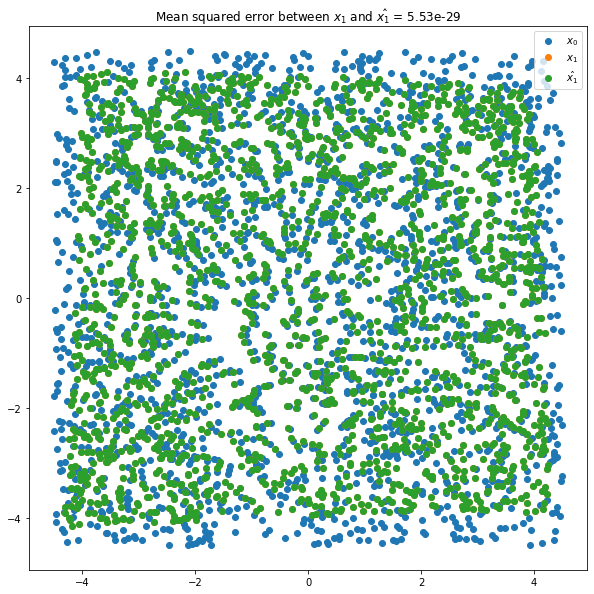

In [13]:
from scipy.interpolate import Rbf

# define Rbf function
delta_t = 0.097
v1 = finite_difference(data_x0, data_x1, delta_t)
rbfi = Rbf(data_x0, v1, epsilon=0.0001, function='gaussian')

# calculate projected x1
new_data_v1 = rbfi(data_x0)
new_data_x1 = calculate_x_from_vector(new_data_v1, data_x0, delta_t)

# calculate mean squared error
mse = mean_squared_error(data_x1, new_data_x1)
# plot original and projected data
fig = plt.figure(figsize=(10,10))
plt.title(r"Mean squared error between $x_1$ and $\hat{x_1}$ = " + f"{mse:.3}")
plt.scatter(data_x0[:,0], data_x0[:,1], label='$x_0$')
plt.scatter(data_x1[:, 0], data_x1[:, 1], label="$x_1$")
plt.scatter(new_data_x1[:, 0], new_data_x1[:, 1], label='$\hat{x_1}$')
plt.legend(loc="upper right")
plt.savefig('task3/Figures/rbf_projected_data_nonlinear')

### Plot phase digram with Rbf function

C:\Users\eminm\anaconda3\lib\site-packages\matplotlib\quiver.py:679: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
C:\Users\eminm\anaconda3\lib\site-packages\matplotlib\quiver.py:679: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


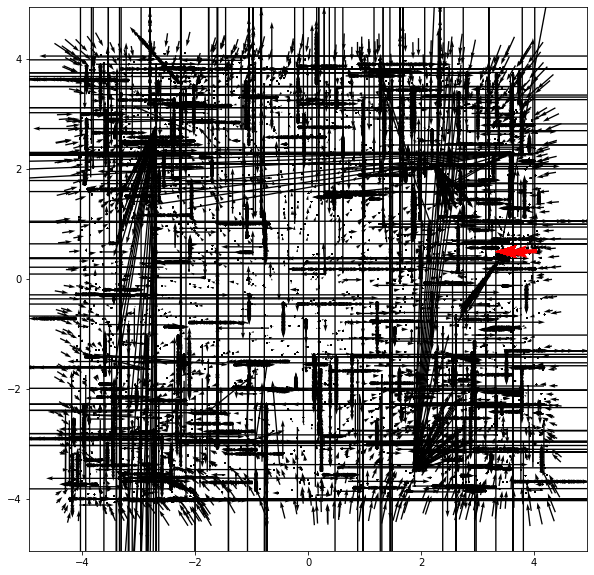

In [14]:
# calculate trajectories for projections
projected_data = []
projected_vectors = []
projected_data.append(data_x0)
fig = plt.figure(figsize=(10,10))

for i in range(100):
        new_v1 = rbfi(projected_data[i])
        new_x = calculate_x_from_vector(new_v1, projected_data[i], delta_t)
        projected_vectors.append(new_v1)
        projected_data.append(new_x)
projected_vectors.append(np.zeros((2000, 2)))

# plot phase diagram
plot_phase_diagram(projected_data, projected_vectors)
plt.savefig('task3/Figures/rbf_nonlinear_phase_diagram')